In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyoff
from scipy import stats
import matplotlib as mpl
%matplotlib inline

In [2]:
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from yellowbrick.contrib.scatter import ScatterVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, adjusted_rand_score
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.manifold import TSNE

In [3]:
from google.colab import drive
drive.mount('/content/drive')

customer_tab= pd.read_csv('/content/drive/MyDrive/base_donnée.csv')
segment_rfm =pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/table_segmentation.csv')

Mounted at /content/drive


In [4]:
segment_rfm.rename(columns={'Nb_inactive_days':'recency','montant':'monetary'}, inplace=True)

In [5]:
segment_rfm.head(3)

,customer_unique_id,recency,frequency,monetary,note_com,frais_livraison,temps_moyen_livraison,Alimentation et Boissons,Auto et Moto,Autres,Livres et Médias,Maison et Jardin,Mode,Santé et Beauté,Sports et Loisirs,Électronique
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,12.00,6.0,0,0,0,0,1,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,8.29,3.0,0,0,0,0,0,0,1,0,0
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,17.22,25.0,0,0,0,0,0,0,0,0,0


In [6]:
customer_tab.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,latitude,longitude,order_id,order_status,order_purchase_timestamp,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,catégorie
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.513713,-47.396644,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,...,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,Autres
1,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,barreiras,BA,-12.147031,-44.996092,a4866dfc455353f48014a2b9a86608a2,delivered,2018-01-11 16:47:03,...,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,Autres
2,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,barreiras,BA,-12.147031,-44.996092,a4866dfc455353f48014a2b9a86608a2,delivered,2018-01-11 16:47:03,...,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,Autres


In [7]:
customer_tab['order_purchase_timestamp'] = pd.to_datetime(customer_tab['order_purchase_timestamp'])

In [8]:
date_min = customer_tab['order_purchase_timestamp'].min()
date_max = customer_tab['order_purchase_timestamp'].max()

In [9]:
date_min

Timestamp('2016-10-03 09:44:50')

In [10]:
date_max

Timestamp('2018-08-29 15:00:37')

In [11]:
(date_max - date_min).days

695

In [12]:
customer_tab.groupby('customer_unique_id')['order_purchase_timestamp'].count()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_purchase_timestamp, Length: 92501, dtype: int64

In [13]:
dates_commande = customer_tab[['customer_unique_id','order_purchase_timestamp']].copy()
dates_commande.columns = ['customer_unique_id', 'Date_dernière_commande']

In [14]:
dates_commande

,customer_unique_id,Date_dernière_commande
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35
1,452fab1c62b178922fc011b0eb89c1b9,2018-01-11 16:47:03
2,452fab1c62b178922fc011b0eb89c1b9,2018-01-11 16:47:03
3,613259d64ba972e49dc25b019b7918c3,2017-12-07 16:41:50
4,aaad33c5051196b5e73c7d65b9072e1d,2018-03-13 20:11:20
...,...,...
114552,20120882a566b99eb67c104dc05d896f,2017-07-09 15:17:43
114553,7c0b4f7719caf8b29a4c8dbd5a1446c9,2018-06-11 16:10:21
114554,640ac18151727c99757e30b92253dbc0,2018-04-29 17:40:51
114555,48f2f72862e37acc97f50b4484ee2af4,2017-10-17 21:50:00


In [15]:
segment_rfm

,customer_unique_id,recency,frequency,monetary,note_com,frais_livraison,temps_moyen_livraison,Alimentation et Boissons,Auto et Moto,Autres,Livres et Médias,Maison et Jardin,Mode,Santé et Beauté,Sports et Loisirs,Électronique
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,12.00,6.0,0,0,0,0,1,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,8.29,3.0,0,0,0,0,0,0,1,0,0
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,17.22,25.0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,17.63,20.0,0,0,0,0,0,0,0,0,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,16.89,13.0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92488,fffcf5a5ff07b0908bd4e2dbc735a684,446,2,4134.84,5.0,248.71,27.0,0,0,0,0,0,0,2,0,0
92489,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,19.69,30.0,0,0,0,0,0,0,1,0,0
92490,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,22.56,14.0,0,1,0,0,0,0,0,0,0
92491,ffff5962728ec6157033ef9805bacc48,118,1,133.69,5.0,18.69,11.0,0,0,0,0,0,1,0,0,0


In [16]:
df = segment_rfm.merge(dates_commande, on = 'customer_unique_id', how = 'inner')

## Méthode

In [17]:
date_min = df['Date_dernière_commande'].min()
date_max = df['Date_dernière_commande'].max()

In [18]:
df['durée_programme'] = (df['Date_dernière_commande'] - date_min).dt.days 

In [19]:
df['group_jours'] = df['durée_programme'] // 15

In [20]:
new_df = df.copy()
new_df = new_df.drop(['customer_unique_id','Date_dernière_commande','durée_programme'], axis = 1)

In [21]:
df1=new_df.groupby('group_jours').agg({
    'recency' : 'median',
    'frequency' : 'median',
    'monetary': 'median', 
    'note_com' : 'median',
    'frais_livraison' : 'median',
    'temps_moyen_livraison' : 'median',
    'group_jours' : 'count'    
})

In [22]:
df['group_jours'].max()

46

In [23]:
scaler = StandardScaler()

In [24]:
orders = pd.read_csv(
    "https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ],
)[["order_id", "customer_id", "order_purchase_timestamp"]].copy()


On peut ainsi programmer une mise à jour de notre programme après 7 mois soit le groupe 

## Méthode retenue

Nous allons calculer le delta de temps entre la première et la dernière commande de notre dataset.

In [25]:
min_date  =orders["order_purchase_timestamp"].min()
max_date=orders["order_purchase_timestamp"].max()

#delta_date = (max_date - min_date).days
delta_date = (date_max - date_min).days
print("Nombre de jours entre la première et la dernière commande : {}".format(delta_date) )

Nombre de jours entre la première et la dernière commande : 695


In [26]:
df

,customer_unique_id,recency,frequency,monetary,note_com,frais_livraison,temps_moyen_livraison,Alimentation et Boissons,Auto et Moto,Autres,Livres et Médias,Maison et Jardin,Mode,Santé et Beauté,Sports et Loisirs,Électronique,Date_dernière_commande,durée_programme,group_jours
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,12.00,6.0,0,0,0,0,1,0,0,0,0,2018-05-10 10:56:27,584,38
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,8.29,3.0,0,0,0,0,0,0,1,0,0,2018-05-07 11:11:27,581,38
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,17.22,25.0,0,0,0,0,0,0,0,0,0,2017-03-10 21:05:03,158,10
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,17.63,20.0,0,0,0,0,0,0,0,0,1,2017-10-12 20:29:41,374,24
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,16.89,13.0,0,0,0,0,0,0,0,0,1,2017-11-14 19:45:42,407,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114544,fffcf5a5ff07b0908bd4e2dbc735a684,446,2,4134.84,5.0,248.71,27.0,0,0,0,0,0,0,2,0,0,2017-06-08 21:00:36,248,16
114545,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,19.69,30.0,0,0,0,0,0,0,1,0,0,2017-12-10 20:07:56,433,28
114546,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,22.56,14.0,0,1,0,0,0,0,0,0,0,2017-02-07 15:49:16,127,8
114547,ffff5962728ec6157033ef9805bacc48,118,1,133.69,5.0,18.69,11.0,0,0,0,0,0,1,0,0,0,2018-05-02 15:17:41,576,38


Nous allons pouvoir calculer un indice ARI en fonction du temps pour notre clustering. Nous allons pour cela vieillir artificiellement les données d'un an afin de vérifier leur stabilité. Cela nous permettra d'afficher un graphique de progression de l'indice ARI.

In [28]:
# Importation des bibliothèques nécessaires
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.simplefilter("ignore")

# Variables
features = ['recency', 'frequency', 'monetary', 'note_com', 'frais_livraison', 'temps_moyen_livraison']

# Définition du seuil de temps pour les données anciennes
duree_stabilité = 15*20 # 336 jours

# Sélection d'un sous-ensemble de données qui viennent après  la duree de stabilité
données_simulation = df[(max_date - df['Date_dernière_commande']) >= pd.Timedelta(days=duree_stabilité)]

données_simulation_scaled = StandardScaler().fit_transform(données_simulation[features])

# Entreinement du KMeans sur les données anciennes (stable)
kmeans_base= KMeans(n_clusters=5,n_init=10 ,random_state=0).fit(données_simulation_scaled)

# Initialisation des listes vides pour les valeurs ARI et les dates
ari_list, days = [], []

#duree_simuation = (695-duree_stabilité)

# Itération à travers les périodes de temps et calcul des valeurs ARI
for i in range(duree_stabilité // 15):

    # Sélection d'un sous-ensemble de données pour la période de temps courante et normalisation
    df_group = df[(max_date - df['Date_dernière_commande']) + pd.Timedelta(days=i*15) >= pd.Timedelta(days=duree_stabilité)]
    X = StandardScaler().fit_transform(df_group[features])
    
    # Entraînement du modèle de clustering KMeans sur les données actuelles et prédiction des étiquettes
    kmeans_retrained = KMeans(n_clusters=5, random_state=0).fit(X)
    labels, labels_true = kmeans_retrained.predict(X), kmeans_base.predict(X)
    
    # Calcul de la valeur ARI et ajout à la liste
    ari_list.append(adjusted_rand_score(labels_true, labels))
    days.append(i * 15)
    
    # Affichage de la valeur ARI pour la période de temps courante
    #print ('Groupe ', df_group['group_jours'].max(), 'avec ', df_group.shape[0], 'données')
    print("ARI pour les données  datant de {} jours : {}".format(i*15, ari_list[-1]))


ARI pour les données  datant de 0 jours : 1.0
ARI pour les données  datant de 15 jours : 0.9902712371608429
ARI pour les données  datant de 30 jours : 0.9808508605200891
ARI pour les données  datant de 45 jours : 0.9095329001027338
ARI pour les données  datant de 60 jours : 0.9035908145764532
ARI pour les données  datant de 75 jours : 0.8880645837010691
ARI pour les données  datant de 90 jours : 0.8764149497825228
ARI pour les données  datant de 105 jours : 0.9164088441039496
ARI pour les données  datant de 120 jours : 0.8788438842040607
ARI pour les données  datant de 135 jours : 0.8741142744881737
ARI pour les données  datant de 150 jours : 0.8718030643528591
ARI pour les données  datant de 165 jours : 0.8856981832431816
ARI pour les données  datant de 180 jours : 0.8790821446529012
ARI pour les données  datant de 195 jours : 0.8738478018091022
ARI pour les données  datant de 210 jours : 0.8650344878266409
ARI pour les données  datant de 225 jours : 0.8520217078509168
ARI pour les do

In [29]:
df.shape    
# Maitenance espacée doit être priviligiée
#- table de jointures.
#- feature.
#- Présentation des k-means pour trois tables.
#- les trois algo de modélisation (silhouette --- temps).
#- Pour DSCAN et ALGO --> Tableau comparatif 
#- Caractérisation et recommandation du meilleur modèle ( radar plot )

(114549, 19)

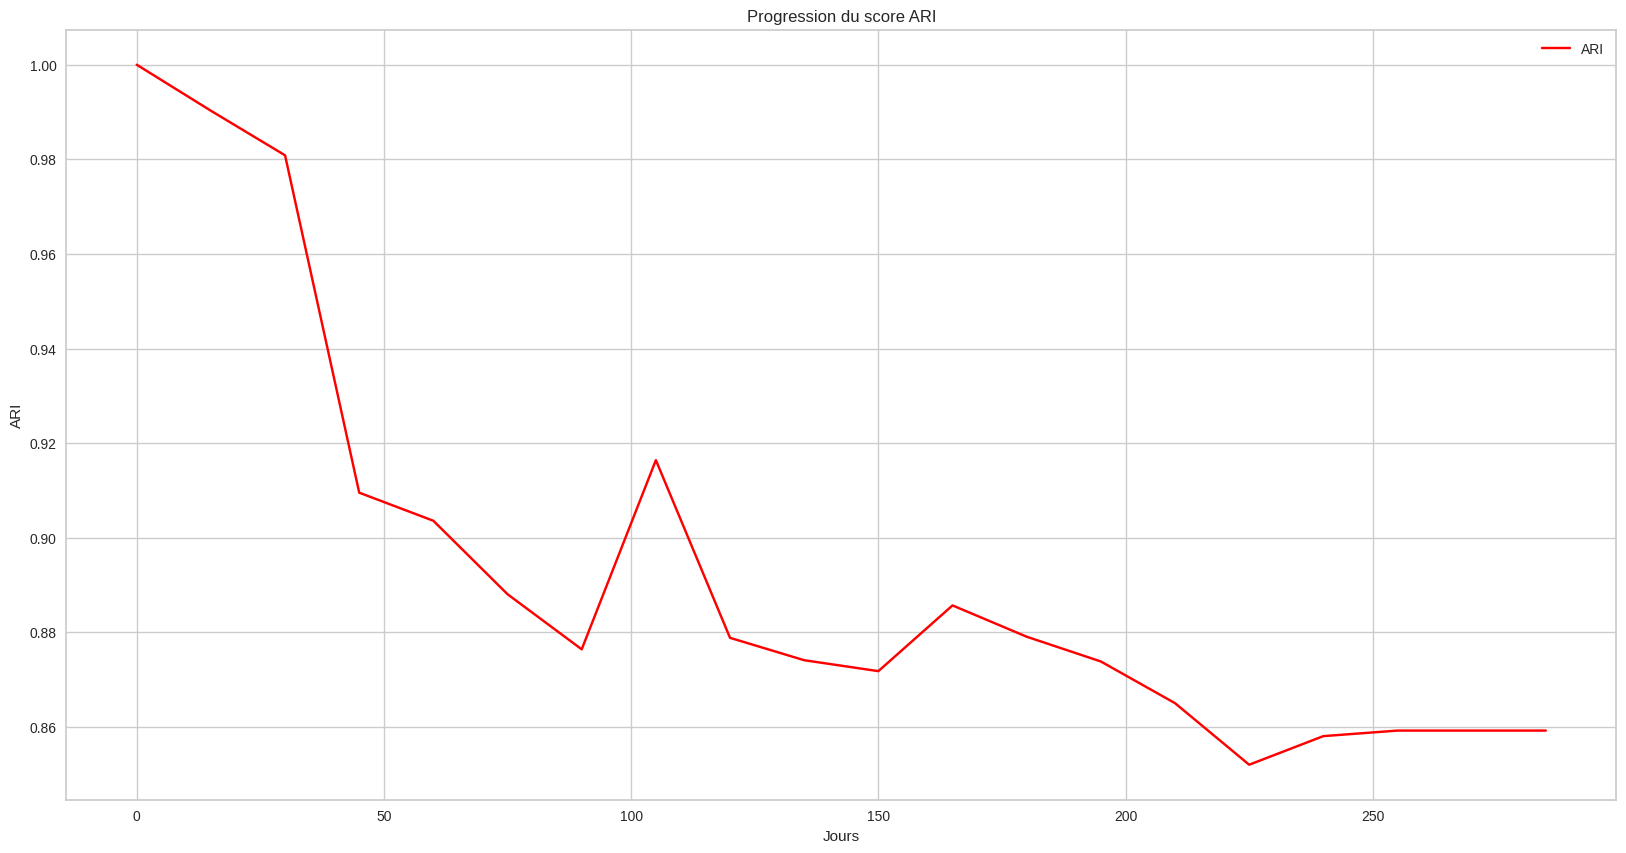

In [30]:
# On affiche le graphique :
plt.figure(figsize=(20,10))
sns.lineplot(x=days, y=ari_list, color='red', label='ARI')
plt.xlabel('Jours')
plt.ylabel('ARI')
plt.title('Progression du score ARI')
plt.show()
